In [1]:
# =========================
# Install Dependencies
# =========================
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn --quiet
!pip install matplotlib seaborn pandas numpy --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Epoch 1/200 - Train Loss: 1.2166, Train Acc: 0.4437 - Val Loss: 1.0065, Val Acc: 0.6100
Epoch 2/200 - Train Loss: 0.9198, Train Acc: 0.6144 - Val Loss: 0.7688, Val Acc: 0.6625
Epoch 3/200 - Train Loss: 0.7782, Train Acc: 0.6931 - Val Loss: 0.6635, Val Acc: 0.7775
Epoch 4/200 - Train Loss: 0.6720, Train Acc: 0.7887 - Val Loss: 0.5419, Val Acc: 0.8950
Epoch 5/200 - Train Loss: 0.5842, Train Acc: 0.8075 - Val Loss: 0.4430, Val Acc: 0.9225
Epoch 6/200 - Train Loss: 0.4891, Train Acc: 0.8575 - Val Loss: 0.3658, Val Acc: 0.9425
Epoch 7/200 - Train Loss: 0.4239, Train Acc: 0.8638 - Val Loss: 0.3107, Val Acc: 0.9350
Epoch 8/200 - Train Loss: 0.4091, Train Acc: 0.8544

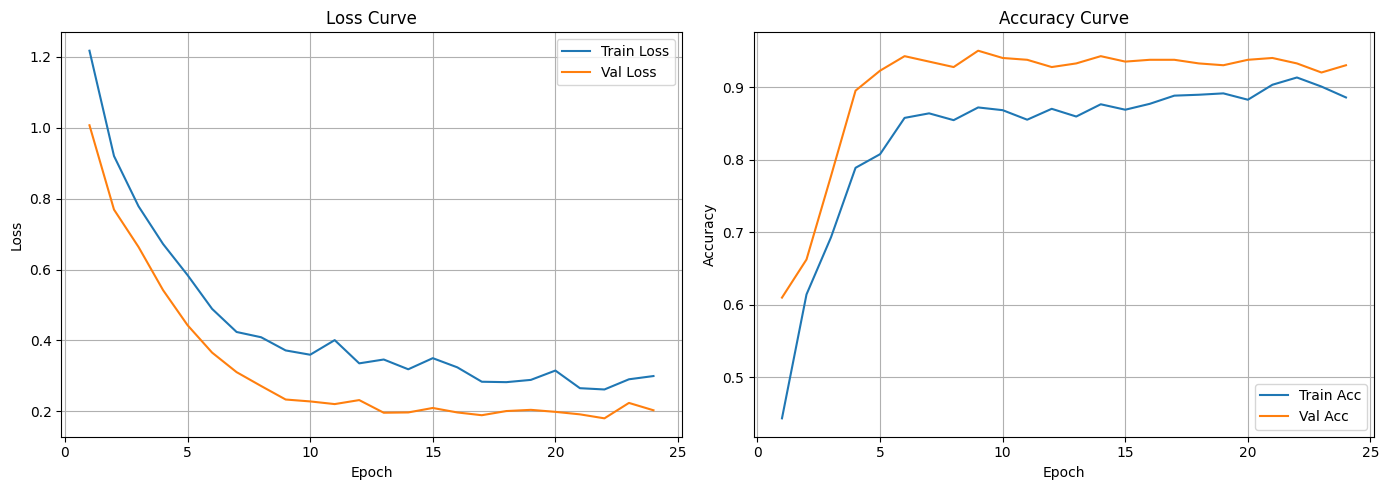

Validation Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       100
           1       0.97      0.92      0.94       100
           2       0.95      0.93      0.94       100
           3       0.94      0.97      0.96       100

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



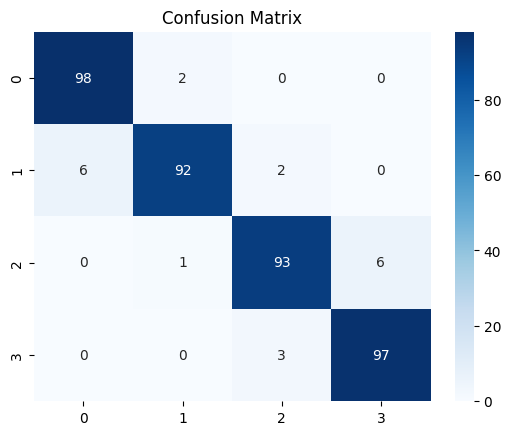

In [2]:
# %%
# =========================
# Install Dependencies
# =========================
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn --quiet
!pip install matplotlib seaborn pandas numpy --quiet

# %%
# =========================
# Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# %%
# =========================
# Load and Preprocess Data
# =========================
df_train = pd.read_csv('train.csv')

# Features and target
X = df_train.drop('price_range', axis=1)
y = df_train['price_range']

# Feature engineering
X['screen_pixels'] = X['px_width'] * X['px_height']
X['total_memory'] = X['ram'] + X['int_memory']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Validation split (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# %%
# =========================
# PyTorch Dataset
# =========================
class MobilePriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MobilePriceDataset(X_train, y_train)
val_dataset = MobilePriceDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# %%
# =========================
# Define High-Performance MLP
# =========================
class MLPHighPerf(nn.Module):
    def __init__(self, input_dim=X_train.shape[1]):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 4)  # Output layer
        )

    def forward(self, x):
        return self.model(x)

# %%
# =========================
# Training Setup
# =========================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPHighPerf().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Early stopping
best_val_acc = 0.0
patience, patience_counter = 15, 0

# %%
# =========================
# Training Loop
# =========================
def train_model(model, train_loader, val_loader, epochs=200):
    global best_val_acc, patience_counter

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Train phase
        model.train()
        train_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        val_acc = correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc)

        # LR scheduler step
        scheduler.step()

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Print metrics
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader)

# %%
# =========================
# Plot Learning Curves
# =========================
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(14,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

# %%
# =========================
# Evaluation
# =========================
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

print('Validation Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# %%
# =========================
# Prediction Function
# =========================
def predict(model, X_test_raw, scaler):
    X_test_scaled = scaler.transform(X_test_raw)
    X_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    return preds



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Shape: (2000, 21)
   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1       

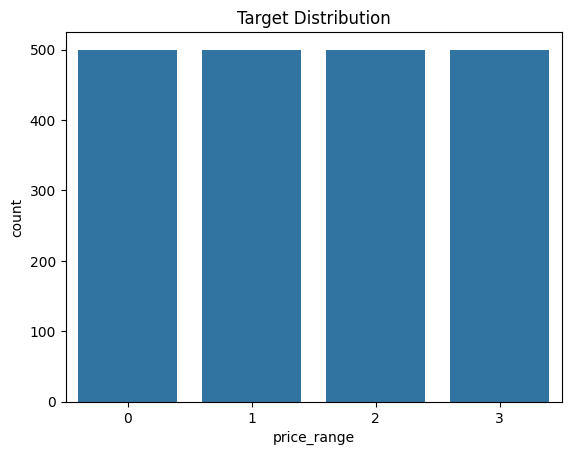

Using device: cpu
Epoch 1/30 - Train Loss: 1.2652, Train Acc: 0.4194 - Val Loss: 1.0894, Val Acc: 0.5425
Epoch 2/30 - Train Loss: 1.0085, Train Acc: 0.5644 - Val Loss: 0.8746, Val Acc: 0.6350
Epoch 3/30 - Train Loss: 0.8637, Train Acc: 0.6244 - Val Loss: 0.7648, Val Acc: 0.6850
Epoch 4/30 - Train Loss: 0.7349, Train Acc: 0.7212 - Val Loss: 0.6903, Val Acc: 0.7350
Epoch 5/30 - Train Loss: 0.6992, Train Acc: 0.7137 - Val Loss: 0.6275, Val Acc: 0.7750
Epoch 6/30 - Train Loss: 0.6410, Train Acc: 0.7319 - Val Loss: 0.5628, Val Acc: 0.8125
Epoch 7/30 - Train Loss: 0.5718, Train Acc: 0.7981 - Val Loss: 0.5081, Val Acc: 0.8450
Epoch 8/30 - Train Loss: 0.5478, Train Acc: 0.7837 - Val Loss: 0.4618, Val Acc: 0.8625
Epoch 9/30 - Train Loss: 0.5009, Train Acc: 0.8094 - Val Loss: 0.4243, Val Acc: 0.8775
Epoch 10/30 - Train Loss: 0.4703, Train Acc: 0.8263 - Val Loss: 0.3844, Val Acc: 0.8900
Epoch 11/30 - Train Loss: 0.4291, Train Acc: 0.8356 - Val Loss: 0.3536, Val Acc: 0.9050
Epoch 12/30 - Train Los

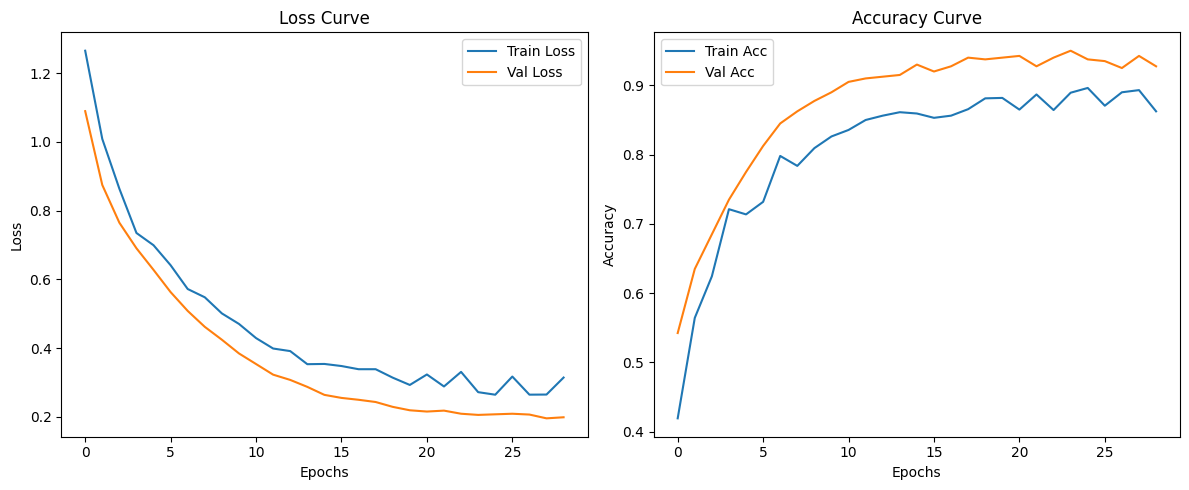

In [25]:
# %%94
# =========================
# Install Dependencies
# =========================
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn --quiet
!pip install matplotlib seaborn pandas numpy --quiet

# %%
# =========================
# Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# %%
# =========================
# Load and Explore Data
# =========================
df = pd.read_csv('train.csv')
print('Shape:', df.shape)
print(df.head())

sns.countplot(x='price_range', data=df)
plt.title('Target Distribution')
plt.show()

# %%
# =========================
# Feature Engineering
# =========================
def create_features(df):
    df = df.copy()
    df['pixel_core_ratio'] = df['px_height'] * df['px_width'] / (df['n_cores'] + 1)
    df['battery_power_per_weight'] = df['battery_power'] / (df['mobile_wt'] + 1)
    df['ram_per_core'] = df['ram'] / (df['n_cores'] + 1)
    return df

df_enhanced = create_features(df)

# %%
# =========================
# Preprocessing
# =========================
X = df_enhanced.drop('price_range', axis=1)
y = df_enhanced['price_range']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# %%
# =========================
# PyTorch Dataset
# =========================
class MobilePriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MobilePriceDataset(X_train, y_train)
val_dataset = MobilePriceDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# %%
# =========================
# MLP Model
# =========================
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128,64], output_dim=4, dropout=0.3):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# %%
# =========================
# Weighted Loss
# =========================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MLPClassifier(input_dim=X.shape[1]).to(device)

# class weights are important if distribution is imbalanced
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

# %%
# =========================
# Training Loop
# =========================
def train_model(model, train_loader, val_loader, epochs=30):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    patience, patience_counter = 5, 0

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        val_acc = correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc)

        scheduler.step(val_acc)

        print(f'Epoch {epoch+1}/{epochs} - '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f} - '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping.')
                break

    return train_losses, val_losses, train_accs, val_accs

train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader)

# %%
# =========================
# Learning Curves
# =========================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Shape: (2000, 21)
   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1       

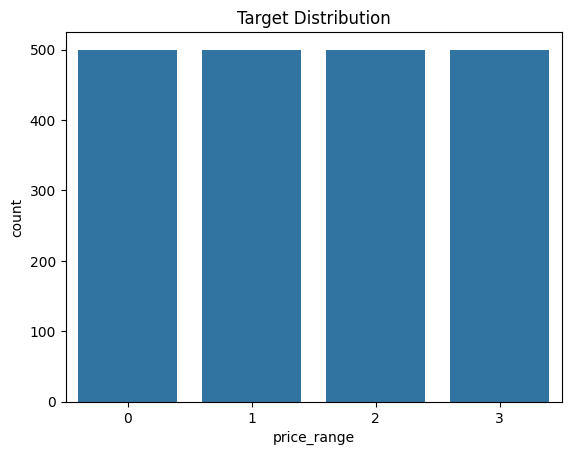

Epoch 1/30 - Train Loss: 1.2570, Train Acc: 0.4213 - Val Loss: 1.1107, Val Acc: 0.5825
Epoch 2/30 - Train Loss: 0.9965, Train Acc: 0.5800 - Val Loss: 0.8713, Val Acc: 0.6500
Epoch 3/30 - Train Loss: 0.8499, Train Acc: 0.6356 - Val Loss: 0.7521, Val Acc: 0.7025
Epoch 4/30 - Train Loss: 0.7410, Train Acc: 0.6950 - Val Loss: 0.6832, Val Acc: 0.7325
Epoch 5/30 - Train Loss: 0.6998, Train Acc: 0.7150 - Val Loss: 0.6295, Val Acc: 0.7500
Epoch 6/30 - Train Loss: 0.6501, Train Acc: 0.7288 - Val Loss: 0.5893, Val Acc: 0.7925
Epoch 7/30 - Train Loss: 0.6099, Train Acc: 0.7631 - Val Loss: 0.5464, Val Acc: 0.8225
Epoch 8/30 - Train Loss: 0.5393, Train Acc: 0.8006 - Val Loss: 0.5007, Val Acc: 0.8425
Epoch 9/30 - Train Loss: 0.5223, Train Acc: 0.7894 - Val Loss: 0.4725, Val Acc: 0.8500
Epoch 10/30 - Train Loss: 0.5000, Train Acc: 0.8156 - Val Loss: 0.4296, Val Acc: 0.8625
Epoch 11/30 - Train Loss: 0.4615, Train Acc: 0.8306 - Val Loss: 0.3980, Val Acc: 0.8950
Epoch 12/30 - Train Loss: 0.4551, Train A

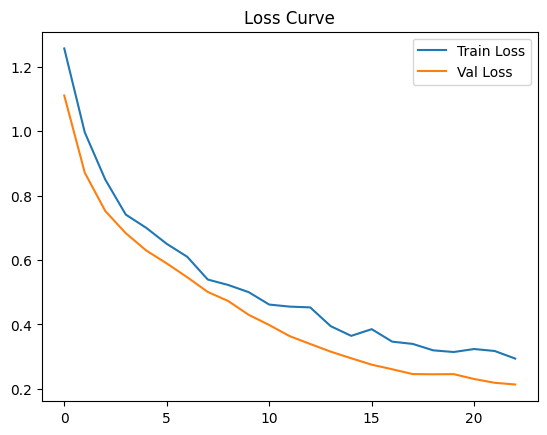

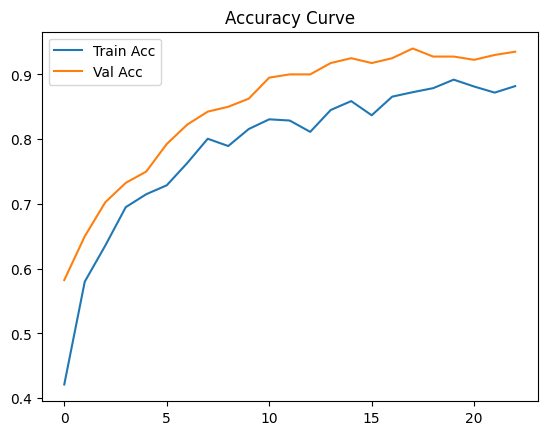

Validation Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       100
           1       0.96      0.90      0.93       100
           2       0.93      0.88      0.90       100
           3       0.92      0.99      0.95       100

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



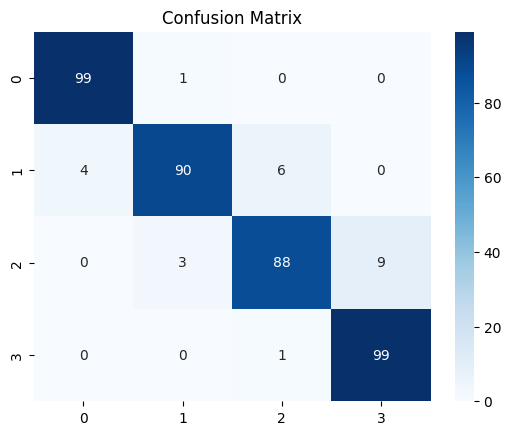

In [26]:
# Mobile Price Classification

# %%
# =========================
# Install Dependencies
# =========================
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn --quiet
!pip install matplotlib seaborn pandas numpy --quiet

# %%
# =========================
# Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# %%
# =========================
# Load and Explore Data
# =========================
df = pd.read_csv('train.csv')
print('Shape:', df.shape)
print(df.head())

sns.countplot(x='price_range', data=df)
plt.title('Target Distribution')
plt.show()

# %%
# =========================
# Preprocessing
# =========================
X = df.drop('price_range', axis=1)
y = df['price_range']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# %%
# =========================
# PyTorch Dataset
# =========================
class MobilePriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MobilePriceDataset(X_train, y_train)
val_dataset = MobilePriceDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# %%
# =========================
# Define MLP Model
# =========================
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], output_dim=4, dropout=0.3):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[1], output_dim)
        )

    def forward(self, x):
        return self.model(x)

# %%
# =========================
# Training Setup
# =========================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPClassifier(input_dim=X.shape[1]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

# %%
# =========================
# Training Loop
# =========================
def train_model(model, train_loader, val_loader, epochs=30):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    patience, patience_counter = 5, 0

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_acc)

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        val_acc = correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f} - Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping.')
                break

    return train_losses, val_losses, train_accs, val_accs

train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader)

# %%
# =========================
# Learning Curves
# =========================
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# %%
# =========================
# Evaluation
# =========================
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

print('Validation Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# %%
# =========================
# Prediction Function
# =========================
def predict(model, X_test_raw, scaler):
    X_test_scaled = scaler.transform(X_test_raw)
    X_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    return preds
